In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [62]:
# Parameters
N_inp = 2000
N_bar = 2000
num_states = 100

In [63]:
cache_states = [20, 30, 70]

In [64]:
place_inputs = PlaceInputs(
    N_inp, num_states, decay_constant=0.0001).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    wide_search_factor=10
    )

# Example Narrow/Broad Recall

In [65]:
def recall_plots(cache_identification, narrow_recall, wide_recall):
    fig, ax = plt.subplots(
        1, 3, figsize=(8,2),
        )
    
    # Identification plot
    readout = np.linalg.norm(cache_identification, axis=1)
    readout /= readout.max()
    ax[0].plot(readout)
    threshold=0.75
    idxs = readout > threshold
    y = readout[idxs]
    y[y>0] = 1.05
    ax[0].scatter(np.arange(100)[idxs], y, s=1, color='red')
    ax[0].set_yticks([0, 0.50, 1.0])
    ax[0].set_ylabel('Output Norm')
    
    # Narrow recall plot
    reconstruct = narrow_recall
    valid_recall = np.any(reconstruct > reconstruct.mean() + 1.5*reconstruct.std(), axis=1)
    ax[1].imshow(reconstruct, aspect='auto')
    #ax[1].set_yticks([0, -(num_states//2), -(num_states)], [0, '$\pi$', '$2\pi$'])
    
    # Wide recall plot
    reconstruct = wide_recall
    valid_recall = np.any(reconstruct > reconstruct.mean() + 1.5*reconstruct.std(), axis=1)
    ax[2].imshow(reconstruct, aspect='auto')
        
    ax[1].set_ylabel('Location')
    ax[2].set_ylabel('')
    ax[2].set_yticks([])
    for _ax in [ax[0]]: # For cache identification
        xtick_loc = []; xtick_label = [];
        for i, c in enumerate(cache_states[:c_idx+1]):
            xtick_loc.append(c)
            xtick_label.append(f'C{i+1}')
    for _ax in ax[1:]: # For recalled place fields
        xtick_loc = []; xtick_label = [];
        for i, c in enumerate(cache_states[:c_idx+1]):
            xtick_loc.append((c/num_states)*N_bar)
            xtick_label.append(f'C{i+1}')
    try: # Only compatible with updated version of Matplotlib
        ax[0].set_xticks(xtick_loc, xtick_label, rotation=45, color='red', fontsize=10)
        ax[1].set_xticks(xtick_loc, xtick_label, rotation=45, color='red', fontsize=10)
        ax[2].set_xticks(xtick_loc, xtick_label, rotation=45, color='red', fontsize=10)
    except:
        pass
    plt.tight_layout()
    plt.show()

In [75]:
downsampling_idxs = list(np.linspace(0, N_inp, num=100, endpoint=False).astype(int))
for c in cache_states:
    idxs = list(np.argwhere(place_inputs[c]>place_inputs[c].min()).flatten())
    downsampling_idxs.extend(idxs)
downsampling_idxs = np.array(downsampling_idxs)
downsampling_idxs = np.sort(np.unique(downsampling_idxs))

Now I just cached at location: 20


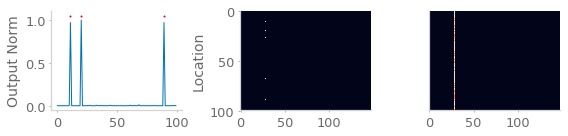

Now I just cached at location: 30


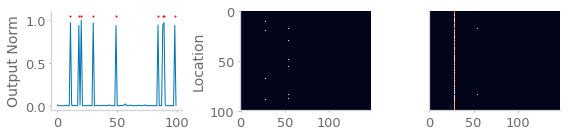

Now I just cached at location: 70


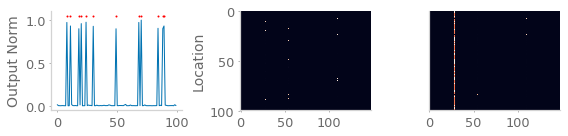

In [76]:
model.reset()

cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(0., place_inputs)
    cache_identification.append(_cache_identification.copy())
    
    _, _, _narrow_recall, _ = model.run_narrow_recall(place_inputs)
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall[:,downsampling_idxs], _wide_recall[:,downsampling_idxs])